In [2]:
import pandas as pd
import numpy as np

df_all = pd.read_csv("../data/WeldedBeam.csv", delimiter=';')
df_all.head()

,Cost,Deflection,x1,x2,x3,x4,g1,g2,g3,g4,Feasible
0,5.770456,0.003272,0.681848,1.429283,9.943629,0.682327,-0.000478,-212.073872,-22529.520520,-1.410969e+05,1
1,3.417618,0.006506,0.354630,3.173719,9.677689,0.372274,-0.017644,-87.439667,-15544.772284,-1.749369e+04,1
2,15.139352,0.001124,0.834153,1.165135,10.000000,1.952282,-1.118129,-612.917676,-27418.406173,-3.451384e+06,1
3,12.833774,0.001352,0.768059,1.308640,9.989048,1.628528,-0.860470,-853.306378,-26898.391239,-1.999474e+06,1
4,18.199209,0.000950,0.932194,1.167533,9.935524,2.355625,-1.423432,-2032.869253,-27832.581568,-6.043640e+06,1


In [6]:
variable_names = [f"x{i}" for i in range(1, 5)]

feasible = df_all["Feasible"].values == 1
fs = df_all[["Cost", "Deflection"]].loc[feasible].copy().reset_index(drop=True)
xs = df_all[variable_names].loc[feasible].copy().reset_index(drop=True)

print(fs.head())
print(xs.head())

        Cost  Deflection
0   5.770456    0.003272
1   3.417618    0.006506
2  15.139352    0.001124
3  12.833774    0.001352
4  18.199209    0.000950
         x1        x2         x3        x4
0  0.681848  1.429283   9.943629  0.682327
1  0.354630  3.173719   9.677689  0.372274
2  0.834153  1.165135  10.000000  1.952282
3  0.768059  1.308640   9.989048  1.628528
4  0.932194  1.167533   9.935524  2.355625


In [13]:
""" Knee: Cost <= 15 & Deflection <= 0.004
    LeftExtreme: Cost <= 10 & Deflection >= 0.005
    RightExtreme: Cost >= 150 & Deflection <= 0.005
    Dominated: Cost >= 80 & Deflection >= 0.020
"""

# Category 1
c1_mask = np.logical_and(fs["Cost"] <= 15.0, fs["Deflection"] <= 0.004)
# Category 2
c2_mask = np.logical_and(fs["Cost"] <= 10.0, fs["Deflection"] >= 0.005)
# Category 3
c3_mask = np.logical_and(fs["Cost"] >= 150.0, fs["Deflection"] <= 0.005)
# Category 4
c4_mask = np.logical_and(fs["Cost"] >= 80.0, fs["Deflection"] >= 0.020)

xs.loc[c1_mask, "category"] = 1
xs.loc[c2_mask, "category"] = 2
xs.loc[c3_mask, "category"] = 3
xs.loc[c4_mask, "category"] = 4

xs_clean = xs[~xs["category"].isnull()]
xs_clean.head()

,x1,x2,x3,x4,category
0,0.681848,1.429283,9.943629,0.682327,1.0
1,0.354630,3.173719,9.677689,0.372274,2.0
3,0.768059,1.308640,9.989048,1.628528,1.0
6,0.746332,1.323172,9.987646,1.199232,1.0
7,0.576860,1.994320,9.958987,0.604042,1.0


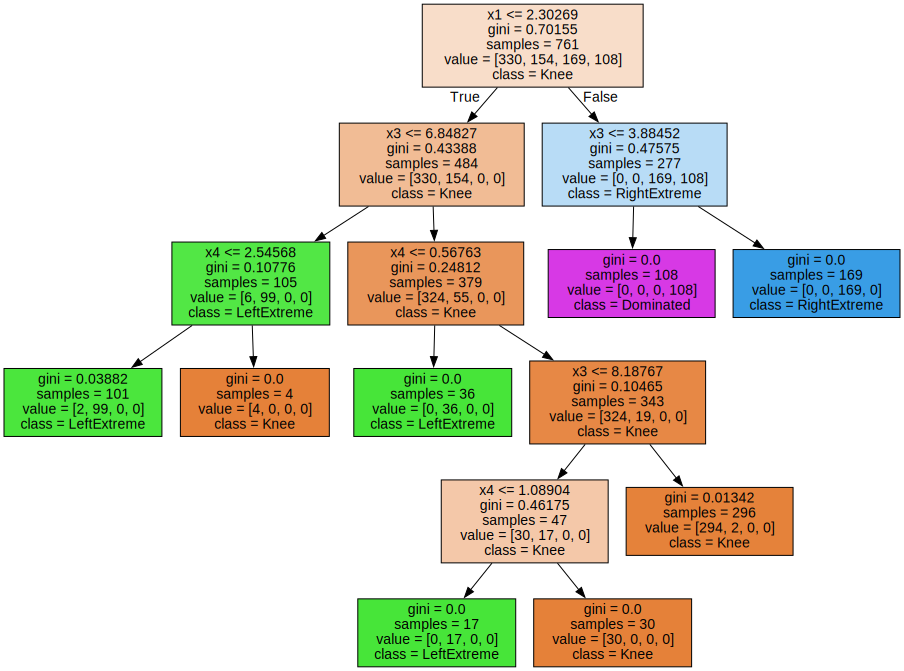

In [14]:
from sklearn import tree
Classifier = tree.DecisionTreeClassifier
from imodels.discretization import ExtraBasicDiscretizer as Discretizer
import graphviz

classifier = Classifier(max_leaf_nodes=8)
classifier.fit(xs_clean[variable_names], xs_clean["category"])

dot_data = tree.export_graphviz(classifier, out_file=None, 
                     feature_names=variable_names,  
                     class_names=["Knee", "LeftExtreme", "RightExtreme", "Dominated"],  
                     filled=True, rounded=False, precision=5,  
                     special_characters=False)  
graph = graphviz.Source(dot_data)  
graph 